In [26]:
def weighted_degree_kernel(s1,s2,d):
    I= 0
    K= 0
    for k in range (1,d+1):
        beta= 2*(d-k+1)/(d*(d+1))
        for l in range (1,(len(s1)-k+1)):
            if (s1[k:l]==s2[k:l]):
                I = I+1
            else:
                I= I+0
        K= K+ (beta * I)          
    return K

In [99]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
sequences=[]
for seq_record in SeqIO.parse('sequencesMSAfasta.sec','fasta'):
    sequences.append(str(seq_record.seq))
#generate possible sequence combinations
s = list(range(0,len(sequences)))
combis= list(itertools.combinations_with_replacement(s, 2))
#init kernel_matrix
kernel_matrix=np.zeros((len(sequences),len(sequences)))
d= 3
#fill kernel matrix
for i in range (len(combis)):
    s1= sequences[combis[i][0]]
    s2= sequences[combis[i][1]]
    kernel_matrix[combis[i][0]][combis[i][1]]= weighted_degree_kernel(s1,s2,d)
    kernel_matrix[combis[i][1]][combis[i][0]]=kernel_matrix[combis[i][0]][combis[i][1]]

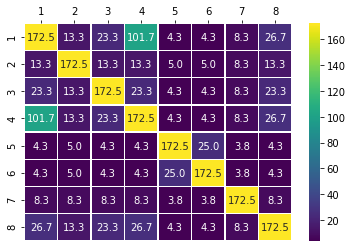

In [100]:
kernel_matrix= pd.DataFrame(kernel_matrix,columns=[1,2,3,4,5,6,7,8])
kernel_matrix.index= [1,2,3,4,5,6,7,8]
ax = sns.heatmap(kernel_matrix, cmap='viridis',annot=True,fmt=".1f",linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.savefig('kernel_matrix.png', dpi=600)